In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
# nltk.download('punkt')
# nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Create a df based on the genres data collected in other steps and reduce it down to key columns
df_genres = pd.read_csv('C:/Users/trist/Labelled_Data.csv')
df_genres = df_genres.loc[:,['artist','track',"cat_numbers"]]

#Create a df based on the lyrics data; do a similar reduction so that the lyrics and join keys are in the df
df_lyrics = pd.read_csv('C:/Users/trist/OneDrive/Desktop/lyrics_new.csv')
df_lyrics = df_lyrics.loc[:,['artist','track',"lyrics"]]

In [3]:
#Merge the lyric and genre data based on the artist and track as keys using an inner join to only bring back matches
df = pd.merge(df_genres,df_lyrics,on=['artist','track'],how='inner')

#Remove the columns that have a null (this would be in the lyrics or genres section)
df = df.dropna()

In [4]:
#Potentially filter out the smaller categories until training data can be expanded to have even classes
df = df[ (df['cat_numbers'] != 'Latin') & (df['cat_numbers'] != 'EDM') & (df['cat_numbers'] != 'Jazz')]

#Check the counts of each genre in the dataset with lyrics
df['cat_numbers'].value_counts()

Rock       378
Country    225
Pop        194
Rap        173
R&B        158
Name: cat_numbers, dtype: int64

In [5]:
# Remove extraneous text (e.g. embedcopy) and verse indicators
new_lyrics = []

#Iterate through the songs
for row in df['lyrics']:
    
    #Convert to a string
    row = str(row)
    
    #remove the embedshare string placed in Genius lyrics
    row = row.replace("EmbedShare URLCopyEmbedCopy","")
    
    #sub the bracket expressions via regex, these are commonly something like [(Shakira) Verse 1:] which are not lyrics
    row = re.sub(r"[\[].*?[\]]", "", row)
    
    #sub line breaks out via regex
    row = re.sub(r"\n+", " ", row)
    
    #sub all other punctuation out via regex
    row = re.sub(r'[^\w\s]', '', row)
    
    #Convert all upper-case words to lower-case
    row = row.lower()
    
    #add new lyrics to the list that will replace the original column
    new_lyrics.append(row)

#Replace the lyrics column with the cleaned lyrics
df['lyrics'] = new_lyrics

In [6]:
#Check out the df after the first round of manipulation and before vectorizing the words using tfidf
df.head()

,artist,track,cat_numbers,lyrics
0,Montgomery Gentry,Lucky Man,Country,i have days where i hate my job this little t...
1,Pretty Ricky,On The Hotline,Rap,its five in the mornin and im up havin phone ...
2,Candlemass,Clouds Of Dementia,Rock,jaded and demented in the attic the bonemen so...
4,Billy Currington,I Got A Feelin',Country,i dont want to rush this thing i dont want to...
6,Alan Jackson,Where I Come From,Country,well i was rolling wheels and shifting gears ...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Create a custom tokenizer so that we can stem or lemmatize words and see how that impacts performance (accuracy)
def tokenize_with_stem(lyrics):
    '''Take lyrics and tokenize them with a stem function e.g. PorterStemmer'''
    #tokenize the lyrics
    tokenized_lyrics = nltk.word_tokenize(lyrics)
    
    #Stem the lyrics after tokenization to get the roots of each token
    stemmed_lyrics = [PorterStemmer().stem(lyric) for lyric in tokenized_lyrics]
    return stemmed_lyrics

#Combine stemming and lemming on stopwords to get dictionary def then boil down to stems in effort to reduce redundancy

#Define stopwords via NLTK english corpus for stopwords
stopwords = set(stopwords.words("english"))

#Stem stops down to their word stems based on root words
stemmed_stops = [PorterStemmer().stem(word) for word in stopwords]

#get our labels for classes
labels = df['cat_numbers']

In [8]:
#Now that we have fully preprocessed, train test split
X_train, X_test, Y_train, Y_test = train_test_split(df['lyrics'], labels, 
                                                    test_size=0.2, random_state=42)

In [9]:
#Set up the vectorizer using tfidf
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='utf-8', ngram_range=(1, 2), stop_words=stemmed_stops)

#run the vectorizer to get the features to determine classification and put the outcomes in an array
X_train = tfidf.fit_transform(X_train).toarray()

X_test = tfidf.transform(X_test).toarray()

features = np.concatenate((X_train,X_test))

labels = np.concatenate((Y_train,Y_test))

In [10]:
X_train.shape

(902, 4189)

In [11]:
#Create a list of models to loop through for performance at baseline level
model_list = [DummyClassifier(strategy="stratified"),
              LogisticRegression(),RandomForestClassifier(random_state=42),
              KNeighborsClassifier(n_neighbors=5),LinearSVC(random_state=42)]

#Cross validate 5x
cv = 5

#Store list of tuples to create df
tuples = []

#Iterate through models and check for CV
for m in model_list:
    cv_acc = np.mean(cross_val_score(m,features,labels))
    
    
    #fit
    m.fit(X_train,Y_train)
    
    #predict
    train_pred = m.predict(X_train)
    test_pred = m.predict(X_test)
    
    #Accuracy test stored in values
    test_acc = accuracy_score(test_pred,Y_test)
    
    tuples.append((m,test_acc,cv_acc))
    
tuples_df = pd.DataFrame(tuples,columns=["Model","Test Accuracy","CV Accuracy"])

In [12]:
#Select optimal model
tuples_df.head()

,Model,Test Accuracy,CV Accuracy
0,DummyClassifier(strategy='stratified'),0.238938,0.226061
1,LogisticRegression(),0.699115,0.663147
2,"(DecisionTreeClassifier(max_features='auto', r...",0.703540,0.640991
3,KNeighborsClassifier(),0.349558,0.373160
4,LinearSVC(random_state=42),0.699115,0.704783


In [13]:
#Tune Hyperparameters for LogReg
c_values = np.logspace(-1,5, 100)

accuracies = []
#Iterate through C_values
for c in c_values:
    
    #Instantiate
    logreg_model = LogisticRegression(C=c, max_iter=10000)
    
    #fit
    logreg_model.fit(X_train,Y_train)
    
    #predict
    train_pred = logreg_model.predict(X_train)
    test_pred = logreg_model.predict(X_test)
    
    #Accuracy on train
    train_acc = accuracy_score(train_pred,Y_train)
    
    #Accuracy on test
    test_acc = accuracy_score(test_pred,Y_test)
    
    #Add pairing to list so convert to df to view results
    accuracies.append((c,train_acc,test_acc))

logreg_results = pd.DataFrame(accuracies, columns=['Regularization Parameter','Train Accuracy','Test_Accuracy'])

In [14]:
logreg_results['Test_Accuracy'].max()

0.7035398230088495

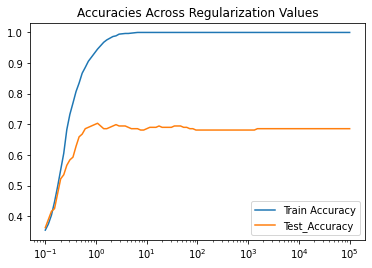

In [15]:
for col in ['Train Accuracy','Test_Accuracy']:
    plt.plot(logreg_results['Regularization Parameter'],logreg_results[col],label=col)
    plt.legend()
    plt.xscale('log')
    plt.title('Accuracies Across Regularization Values')
plt.show()

In [16]:
#Tune Hyperparameters for SVC
c_values = np.logspace(-1,5, 100)

accuracies = []
#Iterate through C_values
for c in c_values:
    
    #Instantiate
    svc_model = LinearSVC(random_state=42,C=c,max_iter=10000)
    
    #fit
    svc_model.fit(X_train,Y_train)
    
    #predict
    train_pred = svc_model.predict(X_train)
    test_pred = svc_model.predict(X_test)
    
    #Accuracy on train
    train_acc = accuracy_score(train_pred,Y_train)
    
    #Accuracy on test
    test_acc = accuracy_score(test_pred,Y_test)
    
    #Add pairing to list so convert to df to view results
    accuracies.append((c,train_acc,test_acc))

svc_results = pd.DataFrame(accuracies, columns=['Regularization Parameter','Train Accuracy','Test_Accuracy'])

In [17]:
svc_results[svc_results['Test_Accuracy']==svc_results['Test_Accuracy'].max()]

,Regularization Parameter,Train Accuracy,Test_Accuracy
0,0.10000,0.909091,0.707965
12,0.53367,0.997783,0.707965


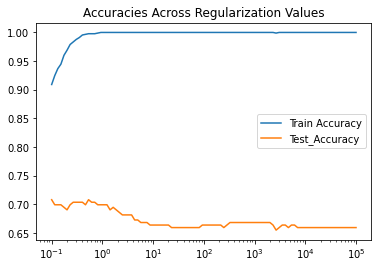

In [18]:
for col in ['Train Accuracy','Test_Accuracy']:
    plt.plot(svc_results['Regularization Parameter'],svc_results[col],label=col)
    plt.legend()
    plt.xscale('log')
    plt.title('Accuracies Across Regularization Values')
plt.show()

In [19]:
#Tune Hyperparameters for KNN
neighbors = [x for x in range(1,50)]

accuracies = []
#Iterate through C_values
for n in neighbors:
    
    #Instantiate
    knn_model = KNeighborsClassifier(n_neighbors=n)
    
    #fit
    knn_model.fit(X_train,Y_train)
    
    #predict
    train_pred = knn_model.predict(X_train)
    test_pred = knn_model.predict(X_test)
    
    #Accuracy on train
    train_acc = accuracy_score(train_pred,Y_train)
    
    #Accuracy on test
    test_acc = accuracy_score(test_pred,Y_test)
    
    #Add pairing to list so convert to df to view results
    accuracies.append((n,train_acc,test_acc))

knn_results = pd.DataFrame(accuracies, columns=['Regularization Parameter','Train Accuracy','Test_Accuracy'])

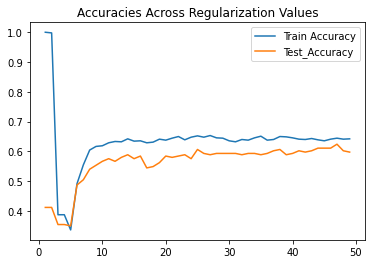

In [20]:
for col in ['Train Accuracy','Test_Accuracy']:
    plt.plot(knn_results['Regularization Parameter'],knn_results[col],label=col)
    plt.legend()
    plt.title('Accuracies Across Regularization Values')
plt.show()

In [21]:
knn_results['Test_Accuracy'].max()

0.6238938053097345

In [22]:
#Random Forest cross val by checking out randomsearchCV

accuracies = []

depths = [x for x in range(1,501,5)]
trees = [x for x in range(1,1001,5)]

param_grid = {
    'max_depth': depths,
    'n_estimators': trees}


random_forest_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy',random_state=42)

#Fit 
random_forest_model.fit(X_train,Y_train)

#Predict
rf_train_preds = random_forest_model.predict(X_train)
rf_test_preds = random_forest_model.predict(X_test)

#Report Out
rf_test_acc = accuracy_score(rf_test_preds,Y_test)
rf_train_acc = accuracy_score(rf_train_preds,Y_train)

accuracies.append((random_forest_model,rf_train_acc,rf_test_acc))
    
rf_df = pd.DataFrame(accuracies, columns=['Model','Train Accuracy','Test_Accuracy'])

In [23]:
rf_df['Test_Accuracy'].max()

0.6902654867256637

In [24]:
confusion_matrix(rf_test_preds,Y_test)

array([[23,  4,  3,  1,  5],
       [ 1,  9,  3,  0,  0],
       [ 2,  6, 11,  1,  0],
       [ 0,  2,  4, 39,  0],
       [13, 19,  4,  2, 74]], dtype=int64)

In [25]:
#MVP model here
c_max = 0.151991

model = LinearSVC(random_state=42,C=c_max,max_iter=10000).fit(X_train,Y_train)

In [27]:
import pickle
#Pickle the model so it can be sent to production
pickle.dump (model, open('genre_pred_model.pickle', 'wb'))

#Also pickle the vectorizer since it is needed to process the data
pickle.dump (tfidf,open('vectorizer.pickle', 'wb'))